We'll be trying to predict hause price with regression models. 

**Let's get started!**
## Check out the data
We've been able to get some data from your neighbor for housing prices as a csv set, let's get our environment ready with the libraries we'll need and then import the data!
### Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
from scipy.stats import norm, skew
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
print(os.listdir('input'))


['data_description.txt', 'test.csv', 'train.csv']


In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')


 mu = 180921.20 and sigma = 79415.29



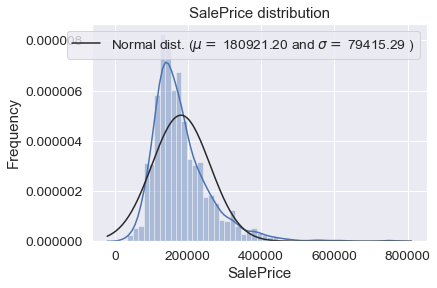

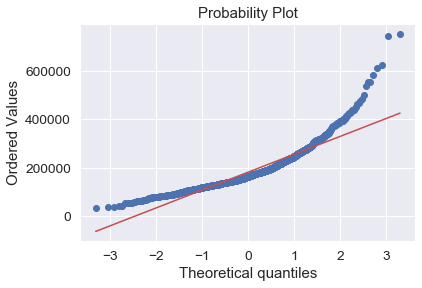

In [342]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show() 

In [344]:
y = train['SalePrice']

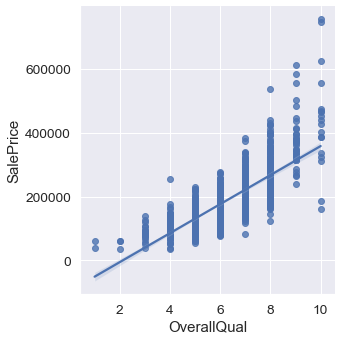

In [345]:
sns.lmplot(x='OverallQual',y='SalePrice',data=train) # 1stFlrSF seems very corelated with SalePrice.

In [346]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [347]:
trainbkp0 = train.copy()
testbkp0 = test.copy()

In [349]:
# VOLTAR BACKUP
train = trainbkp0.copy()
test = testbkp0.copy()

In [350]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True) #SEM RESETAR O INDEX
#all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data = all_data.drop('SalePrice', axis=1)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 80)


In [351]:
#AJUSTE DE AJUSTAR OS VALORES NULOS
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood 
#PREENCHE COM A MEDIA DO BAIRRO
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
#O NULL É SEM GARAGE
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
#QUANDO NAO TEM GARAGE NÃO TEM AREA O OU CARROS PREENCHE COM 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

#PREENCHE COM ZERO PORQUE NÃO TEM PORÃO BASEMENT
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
#PREENCHE COM NONE PORQUE NÃO TEM PORÃO BASEMENT
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
# PREENCHENDO COM O VALOR MAIS COMUM QUE É RL
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
# PREENCHENDO COM O VALOR MAIS COMUM QUE É SBrkr
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
# PREENCHENDO COM O VALOR MAIS COMUM QUE É TA
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# REMOVENDO COLUNA PORQUE SÓ TEM O MESMO VALOR
if 'Utilities' in all_data.columns:
    all_data = all_data.drop(['Utilities'], axis=1)
    all_data = all_data.drop(['Street', 'PoolQC',], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

#Transforming some numerical variables that are really categorical
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#arrumar ano que foi imputado errado
all_data.loc[all_data["GarageYrBlt"] == 2207, "GarageYrBlt"] = 2007

In [353]:
# deletando e melhorando informações de colunas

all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']
all_data['TotalSF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])

all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

objects = []
for i in all_data.columns:
    if all_data[i].dtype == object:
        objects.append(i)
all_data.update(all_data[objects].fillna('None'))

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in all_data.columns:
    if all_data[i].dtype in numeric_dtypes:
        numerics.append(i)
all_data.update(all_data[numerics].fillna(0))

# REMOVER ENVIESAMENTO DE COLUNAS NUMERICAS
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in all_data.columns:
    if all_data[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = all_data[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    all_data[i] = boxcox1p(all_data[i], boxcox_normmax(all_data[i] + 1))
    
# simplificando logica de algumas variáveis
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [354]:
"""RETIRADO PORQUE JÁ FOI TRATADO DE OUTRA FORMA 
ordinal_features = ["ExterQual", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", 
                "LandSlope", "ExterCond", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", 
                "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "LotShape"]
all_data[ordinal_features]
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
all_data[ordinal_features] = all_data[ordinal_features].apply(lambda col: labelencoder.fit_transform(col.astype(str)))
"""
all_data

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,5.318378,1019.567908,0.0,None,3,1Fam,TA,No,117.855827,0.0,...,55.633268,4006,20.763100,2.272893,6.871222,0,1,1,1,0
1,5.550625,0.000000,0.0,None,3,1Fam,TA,Gd,146.805749,0.0,...,31.888691,3952,10.597529,1.673565,21.200425,0,0,1,1,1
2,5.362014,1034.334052,0.0,None,3,1Fam,TA,Mn,91.575258,0.0,...,56.281016,4003,20.697318,2.272893,5.909498,0,1,1,1,1
3,5.388290,899.223997,0.0,None,3,1Fam,Gd,No,52.776355,0.0,...,52.575492,3885,19.634543,1.467818,11.811451,0,1,1,1,1
4,5.493030,1265.202646,0.0,None,4,1Fam,TA,Av,112.040290,0.0,...,61.716748,4000,22.039942,2.272893,21.251630,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,5.041054,643.045587,0.0,None,3,Twnhs,TA,No,0.000000,0.0,...,45.214676,3940,17.327251,1.189489,0.000000,0,1,0,1,0
2915,5.041054,643.045587,0.0,None,3,TwnhsE,TA,No,58.629102,0.0,...,45.214676,3940,17.818790,1.189489,4.657007,0,1,1,1,0
2916,5.532571,0.000000,0.0,None,4,1Fam,TA,No,170.730497,0.0,...,31.509990,3956,11.162474,1.467818,26.181919,0,0,1,1,1
2917,5.393897,0.000000,0.0,None,3,1Fam,TA,Av,71.447821,0.0,...,28.080049,3984,8.224839,1.073895,14.250309,0,0,0,1,0


In [355]:
#separar colunas categorical - retirando colunas numericas
#object_cols = [col for col in all_data.columns if all_data[col].dtype == "object"]
#numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#numeric_cols = [col for col in all_data.columns if all_data[col].dtype in numeric_dtypes]
#all_data[numeric_cols]
# Apply one-hot encoder to each column with categorical data
all_data = pd.get_dummies(all_data).reset_index(drop=True)

In [356]:
all_data

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,5.318378,1019.567908,0.0,3,117.855827,0.0,0.992814,0.00000,30.016555,0.00000,...,0,0,0,0,1,0,0,1,0,0
1,5.550625,0.000000,0.0,3,146.805749,0.0,0.000000,0.71081,44.178889,0.00000,...,0,0,0,0,1,0,1,0,0,0
2,5.362014,1034.334052,0.0,3,91.575258,0.0,0.992814,0.00000,56.957796,0.00000,...,0,0,0,0,1,0,0,1,0,0
3,5.388290,899.223997,0.0,3,52.776355,0.0,0.992814,0.00000,64.881737,15.54214,...,0,0,0,0,1,1,0,0,0,0
4,5.493030,1265.202646,0.0,4,112.040290,0.0,0.992814,0.00000,61.233859,0.00000,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,5.041054,643.045587,0.0,3,0.000000,0.0,0.000000,0.00000,65.309795,0.00000,...,0,0,0,0,1,1,0,0,0,0
2915,5.041054,643.045587,0.0,3,58.629102,0.0,0.000000,0.00000,45.107592,0.00000,...,0,0,0,0,1,1,0,0,0,0
2916,5.532571,0.000000,0.0,4,170.730497,0.0,0.992814,0.00000,0.000000,0.00000,...,0,0,0,0,1,1,0,0,0,0
2917,5.393897,0.000000,0.0,3,71.447821,0.0,0.000000,0.71081,67.351592,0.00000,...,0,0,0,0,1,1,0,0,0,0


In [357]:
#DEPOIS DE AJUSTAR OS VALORES NULOS
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [358]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [359]:
test = test.reset_index(drop=True)
train['SalePrice'] = y

<ipython-input-359-ab47e844b73c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['SalePrice'] = y


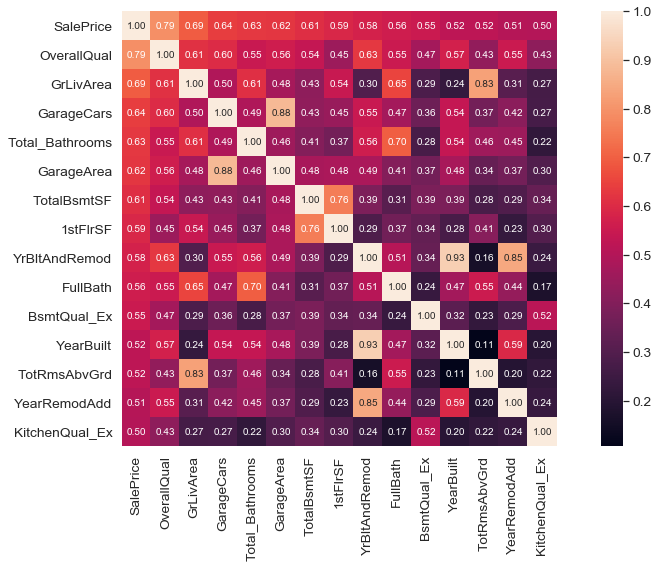

In [360]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
plt.figure(figsize=(16,8))
corrmat = train.corr()
# picking the top 15 correlated features
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [361]:
trainbkp2 = train.copy()
testbkp2 = test.copy()
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['OverallQual']==10) & (train['SalePrice']>690000)].index)
train = train.drop(train[(train['GrLivArea']>2000) & (train['SalePrice']>600000)].index)
train = train.drop(train[(train['GarageCars']==4) & (train['SalePrice']<300000)].index)

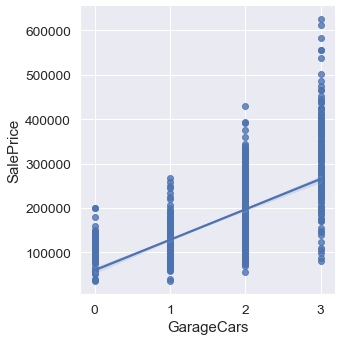

In [362]:
sns.lmplot(x='GarageCars',y='SalePrice',data=train)

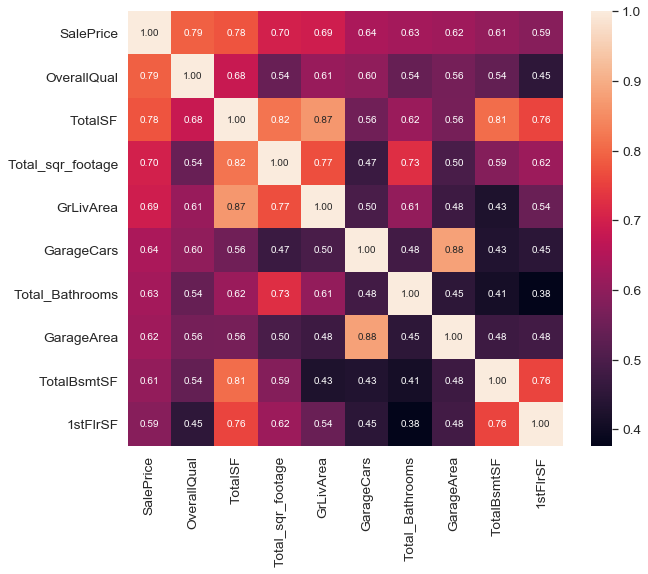

In [298]:
def getZoomedCorrHeatMap(dataFrame,featureCount,target,figSize=[12,9]):
    corrmat = dataFrame.corr()
    cols = corrmat.nlargest(featureCount, target)[target].index
    f , ax = plt.subplots(figsize = (figSize[0],figSize[1]))
    cm = np.corrcoef(dataFrame[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

getZoomedCorrHeatMap(trainbkp2,10,'SalePrice',[10,8])

In [363]:
train['SalePrice'] = trainbkp2['SalePrice']
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice']
train = train.drop('SalePrice', axis=1)

In [364]:
trainbkp2['SalePrice']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [365]:
kfolds = KFold(n_splits=2, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

def cv_rmseArray(model, X):
    rmse = np.sqrt(-cross_val_score(model, np.array(X), np.array(y), scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [366]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [367]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 3, epsilon= 0.008, gamma=0.0003,))

In [368]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
"""params = {'max_depth': 3, 'silent': 1, 'objective': 'reg:squarederror','min_child_weight':1,
          'eval_metric': 'mae', 'learning_rate': 0.01,  'n_estimators':900,
         }
xgboost = XGBRegressor(**params)"""
#'n_jobs':2
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=900,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
stack_gen = StackingCVRegressor(regressors=(ridge, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=lasso,
                                use_features_in_secondary=True)

In [369]:
score = cv_rmse(ridge,train)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
score = cv_rmse(lasso,train)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet,train)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr,train)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm,train)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr,train)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )



RIDGE: 0.1371 (0.0149)
 2020-02-26 18:06:51.272512
LASSO: 0.1354 (0.0174)
 2020-02-26 18:06:51.902947
elastic net: 0.1347 (0.0177)
 2020-02-26 18:06:54.016051
SVR: 0.1386 (0.0184)
 2020-02-26 18:06:54.834758
lightgbm: 0.1373 (0.0078)
 2020-02-26 18:06:57.151661
gbr: 0.1336 (0.0100)
 2020-02-26 18:07:07.707138


In [374]:
params = {'max_depth': 3, 'silent': 1, 'objective': 'reg:squarederror','min_child_weight':1,
          'eval_metric': 'mae', 'learning_rate': 0.05,  'n_estimators':700,
         }
xgboost = XGBRegressor(**params)
score = cv_rmse(xgboost,train)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

xgboost: 0.1348 (0.0104)
 2020-02-26 18:09:35.238435


In [185]:
score = cv_rmseArray(stack_gen,train)
print("stack_gen: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

xgboost: 0.1225 (0.0130)
 2020-02-26 17:25:44.075412


In [375]:
stack_gen.fit(train, y)


StackingCVRegressor(cv=5,
                    meta_regressor=Pipeline(memory=None,
                                            steps=[('robustscaler',
                                                    RobustScaler(copy=True,
                                                                 quantile_range=(25.0,
                                                                                 75.0),
                                                                 with_centering=True,
                                                                 with_scaling=True)),
                                                   ('lassocv',
                                                    LassoCV(alphas=[5e-05,
                                                                    0.0001,
                                                                    0.0002,
                                                                    0.0003,
                                                            

In [376]:
#train
preds = stack_gen.predict(test)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342'] ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'TotalSF', 'YrBltAndRemod', 'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf', 'haspool', 'has2ndfloor', 'hasgarage', 'hasbsmt', 'hasfireplace', 'Alley_Grvl', 'Alley_None', 'Alley_Pave', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_None', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposure_None', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_None', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_None', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_None', 'BsmtQual_TA', 'CentralAir_N', 'CentralAir_Y', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_None', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_None', 'FireplaceQu_Po', 'FireplaceQu_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'Functional_Typ', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_None', 'GarageCond_Po', 'GarageCond_TA', 'GarageFinish_Fin', 'GarageFinish_None', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_None', 'GarageQual_Po', 'GarageQual_TA', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_None', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'MiscFeature_Gar2', 'MiscFeature_None', 'MiscFeature_Othr', 'MiscFeature_Shed', 'MiscFeature_TenC', 'MoSold_1', 'MoSold_10', 'MoSold_11', 'MoSold_12', 'MoSold_2', 'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'OverallCond_1', 'OverallCond_2', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'YrSold_2006', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010']
expected f110, f26, f113, f177, f10, f285, f68, f323, f284, f340, f115, f294, f289, f172, f280, f245, f329, f91, f23, f22, f202, f122, f166, f265, f131, f50, f184, f99, f212, f170, f199, f123, f158, f44, f175, f36, f211, f186, f69, f60, f215, f85, f71, f141, f116, f342, f268, f286, f328, f89, f257, f140, f233, f318, f306, f204, f59, f278, f14, f189, f96, f260, f231, f1, f218, f195, f324, f11, f97, f247, f191, f35, f293, f298, f57, f129, f90, f223, f292, f65, f88, f335, f20, f146, f101, f163, f56, f264, f152, f58, f242, f143, f48, f34, f244, f226, f165, f107, f117, f228, f124, f253, f326, f261, f87, f332, f5, f150, f157, f12, f25, f266, f338, f77, f209, f159, f188, f54, f259, f66, f151, f136, f46, f95, f267, f29, f75, f47, f207, f271, f164, f174, f295, f37, f102, f171, f333, f100, f216, f276, f180, f208, f321, f299, f79, f238, f111, f39, f33, f241, f246, f240, f98, f193, f272, f232, f16, f248, f277, f168, f287, f322, f128, f112, f67, f13, f182, f230, f334, f19, f64, f224, f317, f2, f161, f40, f139, f320, f147, f339, f337, f118, f120, f142, f196, f52, f222, f219, f86, f92, f312, f55, f78, f288, f227, f135, f121, f250, f190, f243, f132, f109, f119, f282, f236, f239, f62, f291, f252, f155, f210, f314, f255, f73, f81, f205, f125, f302, f127, f214, f103, f30, f304, f108, f281, f234, f198, f187, f80, f235, f72, f279, f17, f15, f178, f53, f74, f126, f194, f330, f49, f176, f275, f274, f148, f229, f181, f179, f7, f162, f319, f9, f61, f51, f256, f24, f183, f307, f316, f341, f149, f325, f290, f185, f38, f42, f145, f83, f192, f105, f0, f269, f263, f311, f273, f84, f297, f206, f4, f41, f220, f200, f327, f82, f45, f31, f305, f32, f225, f28, f301, f43, f137, f114, f201, f283, f296, f169, f262, f300, f133, f331, f8, f258, f27, f203, f70, f310, f104, f167, f130, f173, f270, f3, f156, f144, f309, f6, f18, f251, f237, f308, f217, f303, f315, f336, f94, f153, f160, f63, f134, f76, f213, f21, f313, f197, f154, f93, f138, f254, f249, f221, f106 in input data
training data did not have the following fields: BsmtFinType2_Unf, HouseStyle_1.5Fin, Neighborhood_NridgHt, MoSold_9, SaleType_COD, Neighborhood_Sawyer, Heating_Floor, FireplaceQu_Ex, PavedDrive_Y, Heating_Wall, RoofMatl_Membran, EnclosedPorch, OverallCond_8, FireplaceQu_Fa, Exterior2nd_AsbShng, Condition1_RRNn, GarageFinish_Fin, Neighborhood_OldTown, OverallCond_1, Exterior1st_AsphShn, MiscFeature_TenC, Foundation_PConc, SaleType_New, MoSold_3, YrSold_2009, SaleType_Con, Foundation_Wood, MoSold_12, LotShape_IR1, Exterior1st_Stucco, HouseStyle_2.5Unf, GarageCond_TA, SaleCondition_Family, KitchenQual_Gd, Exterior1st_Wd Sdng, MSZoning_FV, ExterCond_Po, PoolArea, HouseStyle_1.5Unf, YrSold_2008, GarageQual_None, BsmtFinType2_GLQ, Neighborhood_IDOTRR, HeatingQC_Gd, BsmtExposure_Av, Heating_GasA, BldgType_Twnhs, Exterior2nd_Stone, Exterior2nd_CBlock, Foundation_CBlock, hasfireplace, HeatingQC_Po, Neighborhood_Gilbert, Neighborhood_NoRidge, TotalBsmtSF, BsmtExposure_Mn, Functional_Min1, Exterior1st_ImStucc, Foundation_Slab, GarageType_Detchd, GarageCars, Exterior1st_CBlock, MSSubClass_75, MSZoning_RM, MiscFeature_Gar2, Fence_GdPrv, ExterQual_Fa, Neighborhood_MeadowV, RoofMatl_Metal, BsmtQual_Ex, BsmtExposure_Gd, ExterCond_TA, Fence_MnPrv, Neighborhood_StoneBr, SaleCondition_Abnorml, GarageCond_Gd, Exterior1st_WdShing, SaleType_ConLI, Condition1_Artery, Condition2_Feedr, BsmtFinType1_ALQ, 1stFlrSF, MSSubClass_45, BldgType_1Fam, BsmtFinType2_LwQ, LandSlope_Sev, ExterCond_Ex, Neighborhood_Blueste, Fence_MnWw, Neighborhood_SWISU, KitchenQual_Fa, Neighborhood_Blmngtn, MoSold_5, LotConfig_Corner, BsmtFullBath, GarageCond_None, has2ndfloor, LotConfig_FR2, MoSold_2, HouseStyle_2.5Fin, HouseStyle_SFoyer, MSZoning_C (all), Exterior2nd_VinylSd, MoSold_8, HouseStyle_1Story, MSSubClass_90, Condition1_RRNe, hasbsmt, LandContour_Low, BsmtFinType2_BLQ, GarageArea, BsmtExposure_None, GarageQual_Ex, GarageType_2Types, BldgType_Duplex, MSSubClass_30, Condition2_RRNn, Neighborhood_NAmes, ExterQual_TA, BsmtQual_Gd, Electrical_FuseF, MoSold_4, GarageType_CarPort, Exterior2nd_Wd Shng, Neighborhood_Somerst, BsmtFinType2_ALQ, ExterQual_Gd, RoofStyle_Shed, MSSubClass_20, OpenPorchSF, YrSold_2010, RoofMatl_CompShg, MasVnrType_BrkFace, OverallCond_9, Total_porch_sf, LotArea, MSSubClass_190, MSSubClass_180, Condition1_RRAn, CentralAir_Y, Exterior1st_HdBoard, MasVnrType_None, SaleType_WD, Neighborhood_Mitchel, WoodDeckSF, MSZoning_RL, Neighborhood_BrkSide, MSSubClass_120, KitchenQual_TA, OverallCond_5, GarageFinish_None, MasVnrType_Stone, CentralAir_N, BsmtFinSF1, SaleType_CWD, MSSubClass_60, Exterior2nd_BrkFace, Electrical_FuseP, GarageYrBlt, Condition2_RRAe, YrSold_2006, Exterior2nd_Other, Condition2_Norm, MoSold_7, HouseStyle_SLvl, Total_sqr_footage, Condition1_PosN, SaleCondition_AdjLand, Exterior2nd_MetalSd, SaleType_ConLD, MasVnrType_BrkCmn, BsmtQual_Fa, OverallCond_3, Exterior2nd_Brk Cmn, RoofMatl_WdShngl, Neighborhood_NWAmes, Condition1_PosA, BsmtFinType2_None, GarageType_Basment, HouseStyle_2Story, MSZoning_RH, LotConfig_Inside, LotConfig_FR3, Functional_Mod, FullBath, GarageQual_Gd, Exterior2nd_CmentBd, LotShape_IR3, FireplaceQu_TA, PavedDrive_P, YrSold_2007, Neighborhood_NPkVill, TotalSF, SaleCondition_Normal, BsmtExposure_No, SaleCondition_Alloca, BldgType_2fmCon, Functional_Min2, LandSlope_Gtl, Exterior2nd_Wd Sdng, RoofMatl_WdShake, Id, Total_Bathrooms, Neighborhood_Veenker, SaleType_Oth, Exterior1st_BrkFace, Electrical_Mix, LowQualFinSF, MSSubClass_40, RoofMatl_Tar&Grv, Neighborhood_Edwards, LandContour_Lvl, Exterior2nd_AsphShn, HalfBath, MoSold_10, Fireplaces, BldgType_TwnhsE, LotFrontage, Exterior1st_CemntBd, Exterior1st_VinylSd, BsmtHalfBath, Neighborhood_ClearCr, LotShape_IR2, Foundation_Stone, GarageType_BuiltIn, FireplaceQu_Po, LandContour_Bnk, RoofStyle_Gambrel, BsmtCond_Fa, GrLivArea, Functional_Maj1, GarageQual_Fa, MSSubClass_70, RoofStyle_Gable, Exterior1st_BrkComm, YearBuilt, MiscFeature_Othr, BsmtQual_TA, Neighborhood_CollgCr, Alley_None, Fence_GdWo, GarageCond_Po, Condition1_RRAe, KitchenAbvGr, ScreenPorch, MiscFeature_Shed, MiscVal, GarageType_Attchd, hasgarage, GarageCond_Ex, Exterior1st_AsbShng, Exterior1st_MetalSd, KitchenQual_Ex, Alley_Pave, GarageFinish_Unf, Condition2_PosN, GarageQual_Po, RoofStyle_Mansard, BsmtFinType1_Unf, Functional_Sev, Electrical_FuseA, Electrical_SBrkr, 3SsnPorch, OverallQual, YrBltAndRemod, LotShape_Reg, LandSlope_Mod, ExterCond_Gd, Neighborhood_Timber, MoSold_11, BedroomAbvGr, BsmtFinType1_Rec, ExterCond_Fa, YearRemodAdd, BsmtFinType1_LwQ, Condition2_PosA, SaleType_ConLw, BsmtCond_TA, OverallCond_6, Condition1_Norm, RoofMatl_Roll, GarageType_None, LandContour_HLS, BsmtCond_Po, Exterior2nd_ImStucc, GarageQual_TA, HeatingQC_Ex, HeatingQC_TA, MSSubClass_160, PavedDrive_N, Condition2_RRAn, BsmtFinType1_BLQ, BsmtFinSF2, Heating_GasW, 2ndFlrSF, BsmtFinType2_Rec, Neighborhood_Crawfor, Exterior1st_Stone, Functional_Typ, BsmtQual_None, HeatingQC_Fa, Heating_Grav, OverallCond_4, Neighborhood_SawyerW, Condition2_Artery, BsmtCond_None, Exterior1st_Plywood, BsmtUnfSF, haspool, RoofStyle_Hip, GarageCond_Fa, MSSubClass_50, TotRmsAbvGrd, MasVnrArea, ExterQual_Ex, Exterior2nd_Stucco, Exterior2nd_HdBoard, MSSubClass_80, FireplaceQu_Gd, Neighborhood_BrDale, RoofMatl_ClyTile, Heating_OthW, LotConfig_CulDSac, Condition1_Feedr, OverallCond_7, MoSold_6, MoSold_1, GarageFinish_RFn, Exterior2nd_Plywood, BsmtFinType1_None, MSSubClass_85, MSSubClass_150, SaleCondition_Partial, Alley_Grvl, BsmtCond_Gd, FireplaceQu_None, Foundation_BrkTil, RoofStyle_Flat, OverallCond_2, Functional_Maj2, BsmtFinType1_GLQ, Fence_None, MiscFeature_None

In [131]:
predsround = np.expm1(preds)

In [132]:
dfID = pd.DataFrame(test['Id'], columns=['Id'])
dfPreds = pd.DataFrame(predsround, columns=['SalePrice'])
dfPreds['SalePrice'] = dfPreds['SalePrice'].astype(float).round(2)

In [134]:
result = pd.concat([dfID,dfPreds], axis=1)

In [136]:
result.to_csv('submissionV11.csv',index=False) 

In [150]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if
                   # X_train[cname].nunique() < 10 and 
                    X_train[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype != "object"]

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='most_frequent')
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
params = {'max_depth': 3, 'silent': 1, 'objective': 'reg:squarederror','min_child_weight':1,
          'eval_metric': 'mae', 'learning_rate': 0.08, 'gamma': 0, 'n_estimators':950}
xgbbost =  XGBRegressor(**params)
model = xgbbost

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
y_trainbkpfinal = y_train.copy()
y_trainbkpfinal = np.log1p(y_train)
# Preprocessing of training data, fit model 
clf.fit(X_train, y_trainbkpfinal)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_test)

print('MAE:', mean_absolute_error(y_test, np.floor(np.expm1(preds))))
print('MSE:', mean_squared_error(np.log1p(y_test), preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, preds)))


c:\users\manager\appdata\local\programs\python\python38\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


MAE: 15487.027397260274
MSE: 0.019668444973751236
RMSE: 195073.11147633928


# TENTATIVA NOVA METODOLOGIA

In [158]:
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train
test

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF
0,856,854,0,None,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,0,2003,2003,2008,2566.0
1,1262,0,0,None,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,298,1976,1976,2007,2524.0
2,920,866,0,None,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,0,2001,2002,2008,2706.0
3,961,756,0,None,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,0,1915,1970,2006,2473.0
4,1145,1053,0,None,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,192,2000,2000,2008,3343.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,0,None,3,1Fam,TA,No,0.0,0.0,...,WD,0,Pave,7,953.0,0,1999,2000,2007,2600.0
1456,2073,0,0,None,3,1Fam,TA,No,790.0,163.0,...,WD,0,Pave,7,1542.0,349,1978,1988,2010,3615.0
1457,1188,1152,0,None,4,1Fam,Gd,No,275.0,0.0,...,WD,0,Pave,9,1152.0,0,1941,2006,2010,3492.0
1458,1078,0,0,None,2,1Fam,TA,Mn,49.0,1029.0,...,WD,0,Pave,5,1078.0,366,1950,1996,2010,2156.0


In [153]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

NameError: name 'X' is not defined

In [95]:
# SUBMISSAO DE TESTE
a = pd.read_csv('input/test.csv')
test_id = a['Id']
a = pd.DataFrame(test_id, columns=['Id'])
preds = clf.predict(test)
preds_df = pd.DataFrame(preds, columns=['SalePrice'])
result = pd.concat([a,preds_df], axis=1)
result.to_csv('submissionV010.csv',index=False)

c:\users\manager\appdata\local\programs\python\python38\lib\site-packages\sklearn\compose\_column_transformer.py:427: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [457]:
clf_pred_notcont = sc_y.inverse_transform(xgbbost_pred)
clf_y_test_notcont = sc_y.inverse_transform(y_test)
clf_pred_notcont = pd.DataFrame(clf_pred_notcont, columns=['SalePricePredict'])
clf_pred_notcont['y_test'] = clf_y_test_notcont
clf_pred_notcont['y_test'] = clf_pred_notcont['y_test'].astype(int)
clf_pred_notcont['SalePricePredict'] = clf_pred_notcont['SalePricePredict'].astype(int)
clf_pred_notcont
print('MAE:', metrics.mean_absolute_error(clf_pred_notcont['y_test'] , clf_pred_notcont['SalePricePredict']))

MAE: 18928.140410958906


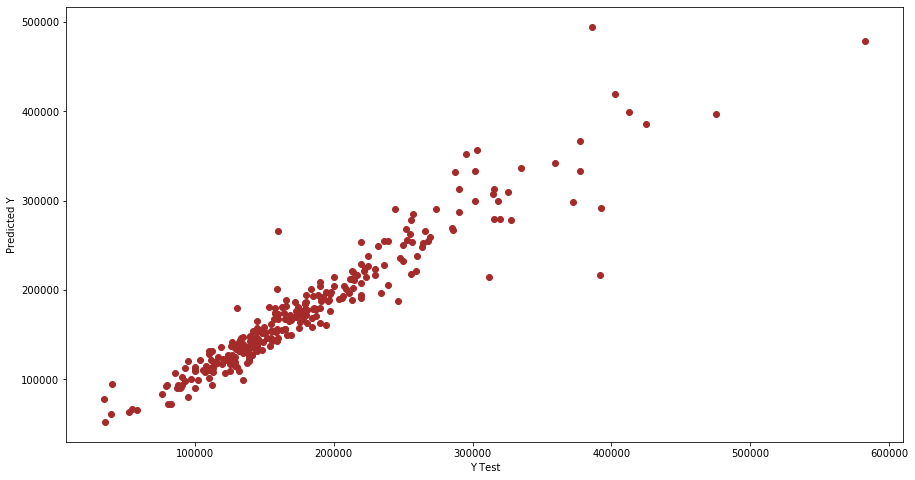

In [126]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,preds, c= 'brown')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

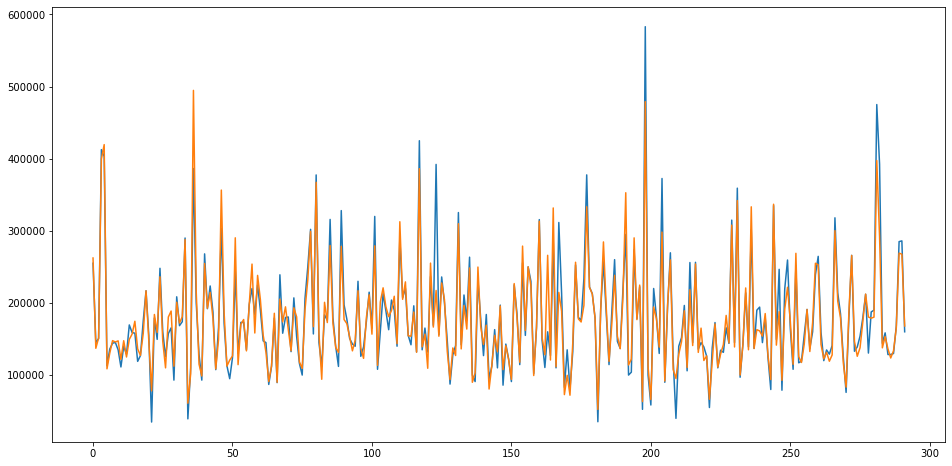

In [144]:
#y_testxpto = y_testxpto.reset_index(drop=True)
plt.figure(figsize=(16,8))
plt.plot(y_testxpto,label ='Test')
plt.plot(preds, label = 'predict')
plt.show()

In [143]:
y_testxpto

0      255000.0
1      145000.0
2      150500.0
3      412500.0
4      402861.0
         ...   
287    129900.0
288    168000.0
289    285000.0
290    286000.0
291    160000.0
Name: SalePrice, Length: 292, dtype: float64

In [418]:
clf_pred_notcont = sc_y.inverse_transform(clf_pred)
clf_y_test_notcont = sc_y.inverse_transform(y_test)
clf_pred_notcont = pd.DataFrame(clf_pred_notcont, columns=['SalePricePredict'])
clf_pred_notcont['y_test'] = clf_y_test_notcont
clf_pred_notcont['y_test'] = clf_pred_notcont['y_test'].astype(int)
clf_pred_notcont['SalePricePredict'] = clf_pred_notcont['SalePricePredict'].astype(int)
clf_pred_notcont
print('MAE:', metrics.mean_absolute_error(clf_pred_notcont['y_test'] , clf_pred_notcont['SalePricePredict']))
#y_test_notcont = sc_y.inverse_transform(y_test)
#y_test_notcont

MAE: 18100.181506849316


<a id="1"></a> <br>
# **Decision Tree Regression **


The decision tree is a simple machine learning model for getting started with regression tasks.

**Background**
A decision tree is a flow-chart-like structure, where each internal (non-leaf) node denotes a test on an attribute, each branch represents the outcome of a test, and each leaf (or terminal) node holds a class label. The topmost node in a tree is the root node. (see here for more details).



In [419]:
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=100, splitter='best')

In [420]:
dtr_pred = dtreg.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)

In [421]:
print('MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))

MAE: 0.356550791263184
MSE: 0.2559746269237732
RMSE: 0.5059393510330791


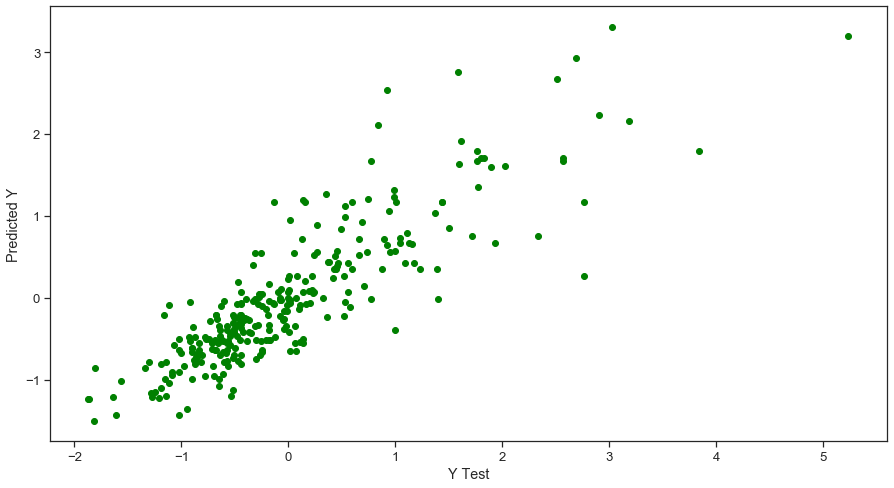

In [422]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,dtr_pred,c='green')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

<a id="1"></a> <br>
# **Support Vector Machine Regression **

Support Vector Machine can also be used as a regression method, maintaining all the main features that characterize the algorithm (maximal margin). The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. First of all, because output is a real number it becomes very difficult to predict the information at hand, which has infinite possibilities. In the case of regression, a margin of tolerance (epsilon) is set in approximation to the SVM which would have already requested from the problem. But besides this fact, there is also a more complicated reason, the algorithm is more complicated therefore to be taken in consideration. However, the main idea is always the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated.


![](https://www.saedsayad.com/images/SVR_1.png)
![](https://www.saedsayad.com/images/SVR_2.png)
***Linear SVR***
                                    ![](https://www.saedsayad.com/images/SVR_4.png)                     
                                    
                                    
                                    
                                    
***Non Linear SVR***

![](https://www.saedsayad.com/images/SVR_6.png)
![](https://www.saedsayad.com/images/SVR_5.png)

In [423]:
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf',C=2.0)
svr.fit(X_train, y_train)


c:\users\manager\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=2.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [424]:
svr_pred = svr.predict(X_test)
svr_pred= svr_pred.reshape(-1,1)

In [425]:
print('MAE:', metrics.mean_absolute_error(y_test, svr_pred))
print('MSE:', metrics.mean_squared_error(y_test, svr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))

MAE: 0.2474626498151001
MSE: 0.15006795080688448
RMSE: 0.38738604880259236


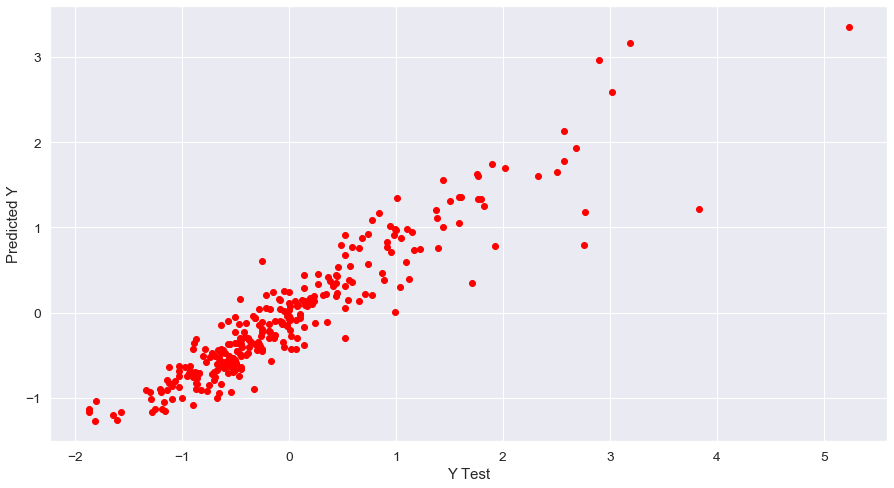

In [265]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,svr_pred, c='red')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

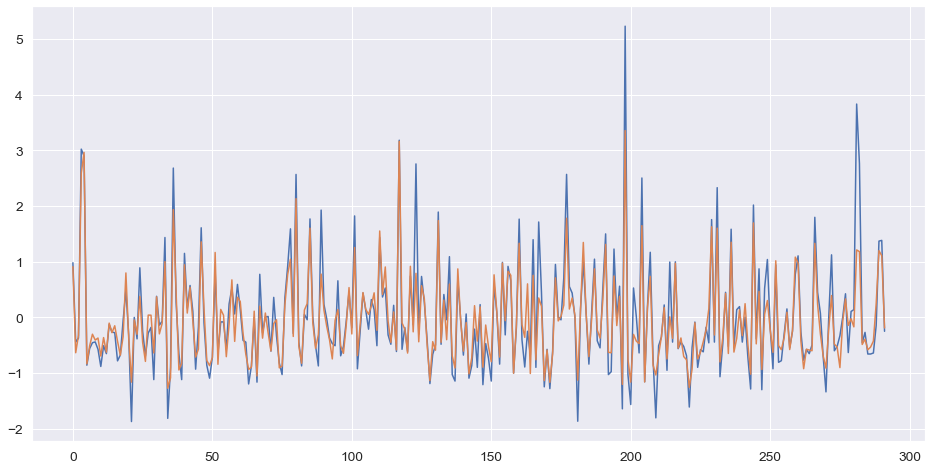

In [266]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(svr_pred, label = 'predict')
plt.show()

<a id="1"></a> <br>
# **Random Forest Regression **

A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation, commonly known as bagging. What is bagging you may ask? Bagging, in the Random Forest method, involves training each decision tree on a different data sample where sampling is done with replacement.

![](https://cdn-images-1.medium.com/max/800/1*jEGFJCm4VSG0OzoqFUQJQg.jpeg)

In [214]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 500, random_state = 0)
rfr.fit(X_train, y_train)


<ipython-input-214-2518e80ff9a6>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [215]:
rfr_pred= rfr.predict(X_test)
rfr_pred = rfr_pred.reshape(-1,1)

In [216]:
print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))

MAE: 0.26020432647250985
MSE: 0.18320086629445137
RMSE: 0.42801970316149157


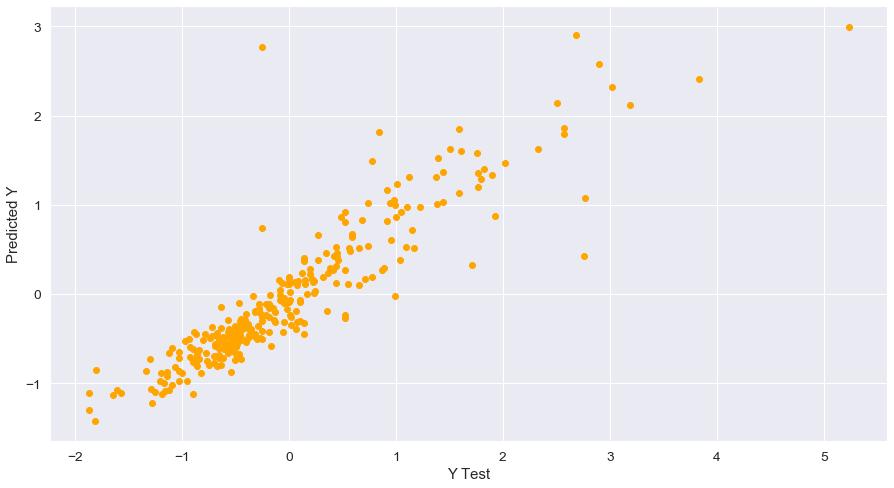

In [217]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,rfr_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

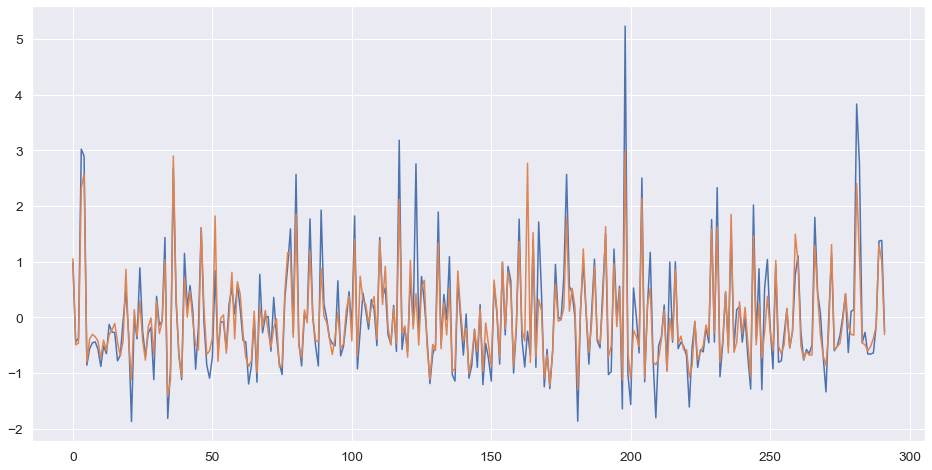

In [218]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(rfr_pred, label = 'predict')
plt.show()

# LightGBM

In [426]:
import lightgbm as lgb

In [436]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.01, n_estimators=3000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(X_train,y_train)
lgb_pred = model_lgb.predict(X_test)
lgb_pred = lgb_pred.reshape(-1,1)

print('MAE:', metrics.mean_absolute_error(y_test, lgb_pred))
print('MSE:', metrics.mean_squared_error(y_test, lgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lgb_pred)))

c:\users\manager\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 0.25498832548480416
MSE: 0.19848640195975095
RMSE: 0.44551812753214765


In [428]:
model_lgb.fit(X_train,y_train)

c:\users\manager\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.01, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=3000, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

MAE: 0.25498832548480416
MSE: 0.19848640195975095
RMSE: 0.44551812753214765


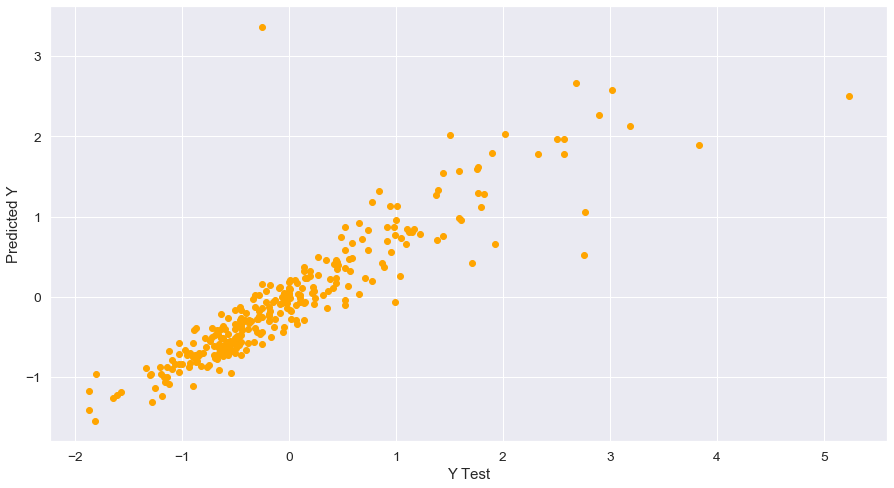

In [224]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,lgb_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

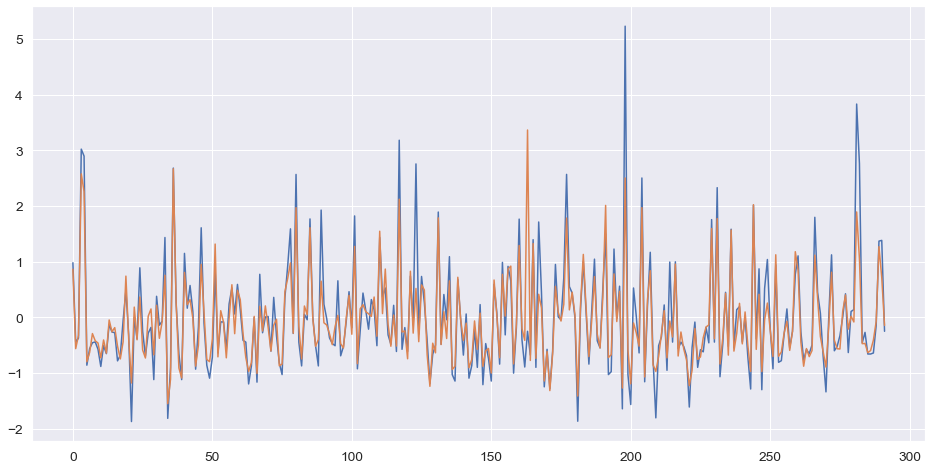

In [225]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(lgb_pred, label = 'predict')
plt.show()

# Model Comparison

**We can say the best working model by loking MSE rates The best working model is Support Vector Machine.**
We are going to see the error rate. which one is better?


In [226]:
error_rate=np.array([metrics.mean_squared_error(y_test, predictions),metrics.mean_squared_error(y_test, clf_pred),metrics.mean_squared_error(y_test, dtr_pred),metrics.mean_squared_error(y_test, svr_pred),metrics.mean_squared_error(y_test, rfr_pred)])

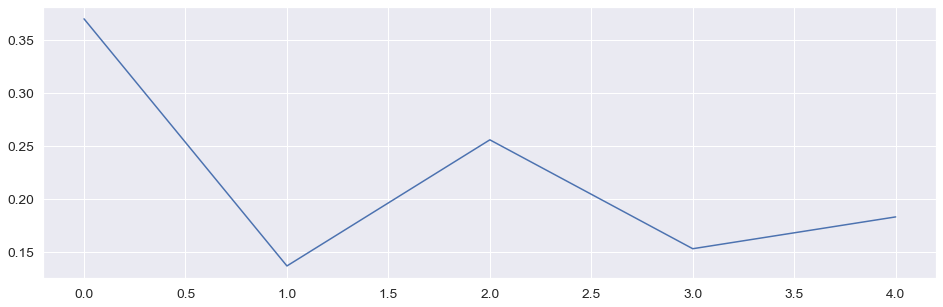

In [227]:
plt.figure(figsize=(16,5))
plt.plot(error_rate)

Now we will use test data .

In [78]:
a = pd.read_csv('../input/test.csv')

In [79]:
test_id = a['Id']
a = pd.DataFrame(test_id, columns=['Id'])

In [80]:
test = sc_X.fit_transform(test)

In [81]:
test.shape

(1459, 14)

In [82]:
test_prediction_lgbm=model_lgb.predict(test)
test_prediction_lgbm= test_prediction_lgbm.reshape(-1,1)

In [83]:
test_prediction_lgbm

array([[-0.75624754],
       [-0.42234108],
       [ 0.02235828],
       ...,
       [-0.11373376],
       [-0.7102517 ],
       [ 0.88751194]])

In [84]:
test_prediction_lgbm =sc_y.inverse_transform(test_prediction_lgbm)

In [85]:
test_prediction_lgbm = pd.DataFrame(test_prediction_lgbm, columns=['SalePrice'])

In [86]:
test_prediction_lgbm.head()

,SalePrice
0,119326.133570
1,145814.057076
2,181090.890730
3,186130.192018
4,197693.319148


In [87]:
result = pd.concat([a,test_prediction_lgbm], axis=1)

In [88]:
result.head()

,Id,SalePrice
0,1461,119326.133570
1,1462,145814.057076
2,1463,181090.890730
3,1464,186130.192018
4,1465,197693.319148


In [89]:
result.to_csv('submission.csv',index=False)

If you like it, please vote :)